In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.losses import mse, binary_crossentropy
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

tf.keras.backend.clear_session()  # For easy reset of notebook state.
np.random.seed(42)
tf.random.set_seed(42)
os.environ["CUDA_VISIBLE_DEVICES"]="3"
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [2]:
def create_lstm_autoencoder(input_dim, timesteps, latent_dim):
    """
    Creates an LSTM Autoencoder (VAE). Returns Autoencoder, Encoder, Generator. 
    (All code by fchollet - see reference.)

    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        latent_dim: int, latent z-layer shape. 

    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
    """

    inputs = Input(shape=(timesteps, input_dim,))
    encoded = LSTM(latent_dim)(inputs)

    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True)(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [7]:
def create_lstm_vae(input_dim, 
    timesteps, 
    batch_size, 
    intermediate_dim, 
    latent_dim,
    epsilon_std=1.):

    """
    Creates an LSTM Variational Autoencoder (VAE). Returns VAE, Encoder, Generator. 

    # Arguments
        input_dim: int.
        timesteps: int, input timestep dimension.
        batch_size: int.
        intermediate_dim: int, output shape of LSTM. 
        latent_dim: int, latent z-layer shape. 
        epsilon_std: float, z-layer sigma.


    # References
        - [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
        - [Generating sentences from a continuous space](https://arxiv.org/abs/1511.06349)
    """
    x = Input(shape=(timesteps, input_dim,))

    # LSTM encoding
    h = LSTM(intermediate_dim)(x)

    # VAE Z layer
    z_mean = Dense(latent_dim)(h)
    z_log_sigma = Dense(latent_dim)(h)
    
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim),
                                  mean=0., stddev=epsilon_std)
        return z_mean + z_log_sigma * epsilon

    # note that "output_shape" isn't necessary with the TensorFlow backend
    # so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    # decoded LSTM layer
    decoder_h = LSTM(intermediate_dim, return_sequences=True)
    decoder_mean = LSTM(input_dim, return_sequences=True)

    h_decoded = RepeatVector(timesteps)(z)
    h_decoded = decoder_h(h_decoded)

    # decoded layer
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end autoencoder
    vae = Model(x, x_decoded_mean)

    # encoder, from inputs to latent space
    encoder = Model(x, z_mean)

    # generator, from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))

    _h_decoded = RepeatVector(timesteps)(decoder_input)
    _h_decoded = decoder_h(_h_decoded)

    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)
    
    xent_loss = mse(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
    loss = xent_loss + kl_loss
    vae.add_loss(loss)
    vae.compile(optimizer='rmsprop')
    
    return vae, encoder, generator

In [8]:
def get_data():
    # read data from file
    data = np.fromfile('sample_data.dat').reshape(419,13)
    timesteps = 3
    dataX = []
    for i in range(len(data) - timesteps - 1):
        x = data[i:(i+timesteps), :]
        dataX.append(x)
    return np.array(dataX)

In [9]:
x = get_data() #415*3*13
input_dim = x.shape[-1] # 13
timesteps = x.shape[1] # 3

Epoch 1/20
13/13 [==============================] - 0s 10ms/step - loss: 0.1969
Epoch 2/20
13/13 [==============================] - 0s 9ms/step - loss: 0.1195
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0877
Epoch 4/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0708
Epoch 5/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0584
Epoch 6/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0483
Epoch 7/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0414
Epoch 8/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0358
Epoch 9/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0323
Epoch 10/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0288
Epoch 11/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0258
Epoch 12/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0240
Epoch 13/20
13/13 [============================

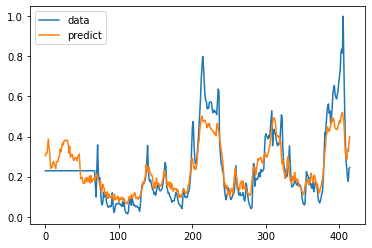

In [13]:
batch_size = 1
vae, enc, gen = create_lstm_vae(input_dim, 
        timesteps=timesteps, 
        batch_size=batch_size, 
        intermediate_dim=32,
        latent_dim=100,
        epsilon_std=1.)

vae.fit(x, x, epochs=20)

preds = vae.predict(x, batch_size=batch_size)

# pick a column to plot.
print("[plotting...]")
print("x: %s, preds: %s" % (x.shape, preds.shape))
plt.plot(x[:,0,3], label='data')
plt.plot(preds[:,0,3], label='predict')
plt.legend()
plt.show()